# Anomaly Detection Based on Generation Models

In this section, we utilize the graph-based generation models to detect the abnormal/malicious data in the log dataset. Generation models are able to learn the underlying data distribution of the normal data. When the model is trained on the normal dataset, if a normal data sample is input and forwared through the model, the reconstruction error after the backward propagation should keeps low. However, if the input is an abnormal data sample, the reconstruction error will be relatively much higher. Therefore, through analyzing the reconstruction error, we are able to detect the abnormal data points feeded into the model. We conducted the data analysis leveraging the [Denoising Diffusion Probabilistic Model][1] (DDPM), with the [Variational Autoencoder][2] (VAE) as the comparison benchmark. Both models are integrated with the [Graph Transformer][3] model to capture the graph information.

The training was conducted on 56,576 normal log graphs. Due to the data loeading and training process of generation models are time-consuming, we used sperate Python files to reconstruct the graph data, collate the data batches, train the models, and saved the trained model parameters. The specific code files and example tensor format are available in the GitHub repository [here](https://github.com/Klasnov/graph_abnormal_detect). In this report section, we will show the code snippets ***without*** executed outputs. The code content in this section is adapted from the tutorial code files, with modifications to our specific dataset application, like the explicit positional encoding of the graph structure based on the log sequence.

[1]: https://arxiv.org/pdf/2006.11239
[2]: https://arxiv.org/pdf/1312.6114
[3]: https://arxiv.org/pdf/2012.09699

## Training Graph Reconstruction with DGL Library

We first load the networkx graph files after the previous data preprocessing. The graph data is then converted to Tensor format with DGL library, as DGL can help to easily extract and manipulate the node and edge features in the graph data.

In the networkx graph, the node features we are going to use are the node type in the computational system and the node log ID. Since some ID values are very frequent appearing in the log data, for each graph with specific size of 100 nodes, we reindex the node local ID, as the node positional encoding later, by random values in the range of 0 to 99. This may avoid the model to overfit on the specific global node ID values. The edge features are the operation type between the nodes.

In [ ]:
import os
import gzip
import networkx as nx
import dgl
import torch
import numpy as np

NUM_NODE = 100

TYPES = ["THREAD", "FILE", "REGISTRY", "FLOW", "USER_SESSION", "SERVICE", "PROCESS", "MODULE", "TASK", "SHELL"]
TYPE_MAP = {type: i for i, type in enumerate(TYPES)}

ACTIONS = [
    "FILE_CREATE", "FILE_DELETE", "FILE_MODIFY", "FILE_READ", "FILE_RENAME",
    "FILE_WRITE", "FLOW_MESSAGE", "FLOW_OPEN", "MODULE_LOAD", "PROCESS_CREATE",
    "PROCESS_OPEN", "PROCESS_TERMINATE", "REGISTRY_ADD", "REGISTRY_EDIT",
    "REGISTRY_REMOVE", "SERVICE_CREATE", "SHELL_COMMAND", "TASK_CREATE",
    "TASK_DELETE", "TASK_MODIFY", "TASK_START", "THREAD_CREATE", "THREAD_REMOTE_CREATE",
    "THREAD_TERMINATE", "USER_SESSION_GRANT", "USER_SESSION_INTERACTIVE","USER_SESSION_LOGIN",
    "USER_SESSION_LOGOUT", "USER_SESSION_REMOTE", "USER_SESSION_UNLOCK"
    ]
ACTION_MAP = {action: i for i, action in enumerate(ACTIONS)}

def nx_to_dgl(nx_graph):
    dgl_graph = dgl.graph(([], []))

    node_ids = list(nx_graph.nodes)
    dgl_graph.add_nodes(len(node_ids))
    nx_to_dgl_node_map = {node: i for i, node in enumerate(node_ids)}
    if len(node_ids) != NUM_NODE:
        raise ValueError("Number of nodes in graph is not 100")
    
    id_set = set()
    for node in node_ids:
        node_data = nx_graph.nodes[node]
        node_id = node_data.get("nodeID", -1)
        id_set.add(node_id)
    
    # Map nodeIDs to random integer in range of [0, 99], avoid overfitting to nodeIDs
    id_set_len = len(id_set)
    rand_ids = np.random.choice(100, id_set_len, replace=False)
    rand_id_Map = {node_id: rand_id for node_id, rand_id in zip(id_set, rand_ids)}
    
    # Map node features
    node_types = []
    ids = []
    
    for node in node_ids:
        node_data = nx_graph.nodes[node]
        node_type = node_data.get("node_type", "")
        node_id = node_data.get("nodeID", -1)
        node_types.append(TYPE_MAP.get(node_type, -1))
        ids.append(rand_id_Map.get(node_id, -1))
    
    dgl_graph.ndata["type"] = torch.tensor(node_types, dtype=torch.float32)
    dgl_graph.ndata["id"] = torch.tensor(ids, dtype=torch.float32)
    
    # Map edge features
    edges = list(nx_graph.edges(data=True))
    src_nodes = []
    dst_nodes = []
    edge_actions = []
    
    for edge in edges:
        src, dst, edge_data = edge
        src_nodes.append(nx_to_dgl_node_map[src])
        dst_nodes.append(nx_to_dgl_node_map[dst])
        edge_actions.append(ACTION_MAP.get(edge_data.get("action", ""), -1))
    
    dgl_graph.add_edges(src_nodes, dst_nodes)
    dgl_graph.edata["action"] = torch.tensor(edge_actions, dtype=torch.float32)
    
    return dgl_graph



dir_path = "data/train_graphs/"
if not os.path.exists(dir_path):
    raise ValueError("The path does not exist")

train_graph_list = []
for chid_dirs in os.listdir(dir_path):
    chid_dirs_path = os.path.join(dir_path, chid_dirs)
    if not os.path.isdir(chid_dirs_path):
        continue
    for file in os.listdir(chid_dirs_path):
        if file.endswith(".gz"):
            file_path = os.path.join(chid_dirs_path, file)
            with gzip.open(file_path, "rb") as f:
                nx_graph = nx.read_gml(f)
                dgl_graph = nx_to_dgl(nx_graph)
                train_graph_list.append(dgl_graph)

## Data Batching and Storage in Tensor Format

To make the training process more efficient, we collate the graph data into batches with batch size of 32. The batched graph data is saved in the PyTorch tensor format, which can be directly loaded in the training process.

In this process, the edge features are converted from the coordinate sparse matrix format (COO) into the dense weighted adjacency matrix format.

In [ ]:
import os
import torch
from math import ceil


BATCH_SIZE = 32


def get_weighted_adjacency_matrix(graph):
    adj_spr = graph.adjacency_matrix(scipy_fmt="coo")
    edge_freq = graph.edata["action"]
    num_nodes = graph.number_of_nodes()
    adj = torch.zeros(num_nodes, num_nodes)
    for i, j, freq in zip(adj_spr.row, adj_spr.col, edge_freq):
        adj[i, j] = freq
    adj = adj + adj.T
    return adj


def batch_save(graph_list, path, index, batch_size=32):
    if len(graph_list) < batch_size:
        batch_size = len(graph_list)
    node_type_list = []
    node_id_list = []
    edge_action_list = []
    for graph in graph_list:
        node_type_list.append(graph.ndata["type"])
        node_id_list.append(graph.ndata["id"])
        adj = get_weighted_adjacency_matrix(graph)
        edge_action_list.append(adj)
    h = torch.cat(node_type_list, dim=0).view(batch_size, 100).long()
    pe = torch.cat(node_id_list, dim=0).view(batch_size, 100).long()
    e = torch.cat(edge_action_list, dim=0).view(batch_size, 100, 100).long()
    torch.save(h, path + "h_" + str(index) + ".pt")
    torch.save(pe, path + "pe_" + str(index) + ".pt")
    torch.save(e, path + "e_" + str(index) + ".pt")
    return h, pe, e


def batch_graph(graph_list=None, batch_size=32, path="data/train/", index=0, load=True):
    if not load:
        if not os.path.exists(path):
            os.makedirs(path)
        num_batch = ceil(len(graph_list) / batch_size)
        for i in range(num_batch):
            end_batch_index = (i + 1) * batch_size
            if end_batch_index > len(graph_list):
                end_batch_index = len(graph_list)
            batch_graph_list = graph_list[i * batch_size: end_batch_index]
            save_path = path + "batch_" + str(i) + "/"
            if not os.path.exists(save_path):
                os.makedirs(save_path)
            batch_save(batch_graph_list, save_path, i)
            h = None; pe = None; e = None
    else:
        save_path = path + "batch_" + str(index) + "/"
        if not os.path.exists(save_path):
            raise ValueError("The path does not exist")
        h = torch.load(save_path + "h_" + str(index) + ".pt", weights_only=True)
        pe = torch.load(save_path + "pe_" + str(index) + ".pt", weights_only=True)
        e = torch.load(save_path + "e_" + str(index) + ".pt", weights_only=True)
    return h, pe, e


_, _, _ = batch_graph(train_graph_list, batch_size=BATCH_SIZE, load=False)

## Training Script for DDPM Model

The training script for the Denoising Diffusion Probabilistic Model (DDPM) is shown below. The model is trained with the batched graph data, and the trained model parameters are saved for the later reconstruction and analysis process.

The batch size was set to 32, with the number of batches was 1768. Total 1000 epochs were set for the training process. The initial learning rate was set to 0.0003. We adapt the Adam optimizer for the model training as the tutorial code. Warmup learning rate scheduler and reduce learning rate on plateau scheduler are also used in the training process. The loss function used in the training process is the mean squared error (MSE) loss to identify whether the model correctly learned the denoising process.

In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_NODE = 100
TYPES = ["THREAD", "FILE", "REGISTRY", "FLOW", "USER_SESSION", "SERVICE", "PROCESS", "MODULE", "TASK", "SHELL"]
ACTIONS = [
    "FILE_CREATE", "FILE_DELETE", "FILE_MODIFY", "FILE_READ", "FILE_RENAME", "FILE_WRITE", "FLOW_MESSAGE",
    "FLOW_OPEN", "MODULE_LOAD", "PROCESS_CREATE", "PROCESS_OPEN", "PROCESS_TERMINATE", "REGISTRY_ADD",
    "REGISTRY_EDIT", "REGISTRY_REMOVE", "SERVICE_CREATE", "SHELL_COMMAND", "TASK_CREATE", "TASK_DELETE",
    "TASK_MODIFY", "TASK_START", "THREAD_CREATE", "THREAD_REMOTE_CREATE", "THREAD_TERMINATE", "USER_SESSION_GRANT",
    "USER_SESSION_INTERACTIVE","USER_SESSION_LOGIN", "USER_SESSION_LOGOUT", "USER_SESSION_REMOTE", "USER_SESSION_UNLOCK"
]
NUM_BATCH = 1768
NUM_GRAPH = NUM_BATCH * BATCH_SIZE
NUM_WARMUP = 2 * max(NUM_NODE, NUM_GRAPH // BATCH_SIZE)

EPOCH_NUM = 1000
INIT_LR = 0.0003


def get_weighted_adjacency_matrix(graph):
    adj_spr = graph.adjacency_matrix(scipy_fmt="coo")
    edge_freq = graph.edata["action"]
    num_nodes = graph.number_of_nodes()
    adj = torch.zeros(num_nodes, num_nodes)
    for i, j, freq in zip(adj_spr.row, adj_spr.col, edge_freq):
        adj[i, j] = freq
    adj = adj + adj.T
    return adj


def get_batch(path="data/train/", index=0):
    save_path = path + "batch_" + str(index) + "/"
    if not os.path.exists(save_path):
        raise ValueError("The path does not exist")
    h = torch.load(save_path + "h_" + str(index) + ".pt", weights_only=True)
    pe = torch.load(save_path + "pe_" + str(index) + ".pt", weights_only=True)
    e = torch.load(save_path + "e_" + str(index) + ".pt", weights_only=True)
    return h, pe, e


def sym_tensor(x):
    x = x.permute(0, 3, 1, 2) # [bs, n, n, d]
    triu = torch.triu(x,diagonal=1).transpose(3,2) # [bs, d, n, n]
    mask = (triu.abs()>0).float()                  # [bs, d, n, n]
    x =  x * (1 - mask ) + mask * triu             # [bs, d, n, n]
    x = x.permute(0, 2, 3, 1) # [bs, n, n, d]
    return x               # [bs, n, n, d]

class Embed_G(nn.Module):
    def __init__(self, params):
        super().__init__()
        d = params["d"]
        self.Embed_h = nn.Embedding(params["num_type"], d)
        self.Embed_e = nn.Embedding(params["num_action"], d)
        self.Embed_pe = nn.Embedding(params["num_node"], d)
    
    def forward(self, h, e, pe):
        pe = self.Embed_pe(pe) # [bs, n, d]
        h = self.Embed_h(h)
        h = h + pe
        e = self.Embed_e(e) # [bs, n, n, d]
        e = e + pe.unsqueeze(1) + pe.unsqueeze(2)
        e = sym_tensor(e)
        return h, e


class Attention_Layer(nn.Module):
    def __init__(self, d, d_head, drop):
        super().__init__()
        self.Q = nn.Linear(d, d_head)
        self.K = nn.Linear(d, d_head)
        self.V = nn.Linear(d, d_head)
        self.E = nn.Linear(d, d_head)
        self.Ni = nn.Linear(d, d_head)
        self.Nj = nn.Linear(d, d_head)
        self.Drop_Att = nn.Dropout(drop)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
    
    def forward(self, h, e):
        # h: [bs, n, d]; e: [bs, n, n, d]
        Q = self.Q(h) # [bs, n, d_head]
        K = self.K(h)
        V = self.V(h)
        Q = Q.unsqueeze(2)  # [bs, n, 1, d_head]
        K = K.unsqueeze(1)  # [bs, 1, n, d_head]
        E = self.E(e)       # [bs, n, n, d_head]
        Ni = self.Ni(h).unsqueeze(2) # [bs, n, 1, d_head]
        Nj = self.Nj(h).unsqueeze(1) # [bs, 1, n, d_head]
        e = E + Ni + Nj              # [bs, n, n, d_head]
        Att = (Q * e * K).sum(dim=-1) / self.sqrt_d # [bs, n, n]
        Att = torch.softmax(Att, dim=1)             # [bs, n, n]
        Att = self.Drop_Att(Att)
        h = Att @ V # [bs, n, d_head]
        return h, e


class MAH_Layer(nn.Module):
    def __init__(self, d, head_num, drop):
        super().__init__()
        d_head = d // head_num
        self.heads = nn.ModuleList([Attention_Layer(d, d_head, drop) for _ in range(head_num)])
        self.WO_h = nn.Linear(d, d)
        self.WO_e = nn.Linear(d, d)
        self.Drop_h = nn.Dropout(drop)
        self.Drop_e = nn.Dropout(drop)
    
    def forward(self, h, e):
        # h: [bs, n, d]; e: [bs, n, n, d]
        h_MHA = []
        e_MHA = []
        for head in self.heads:
            h_mha, e_mha = head(h, e)
            h_MHA.append(h_mha)
            e_MHA.append(e_mha)
        h = self.Drop_h(self.WO_h(torch.cat(h_MHA, dim=2)))
        e = self.Drop_e(self.WO_e(torch.cat(e_MHA, dim=3)))
        return h, e


class GT_Layer(nn.Module):
    def __init__(self, d, num_head, drop):
        super().__init__()
        self.Norm_h_1 = nn.LayerNorm(d)
        self.Norm_e_1 = nn.LayerNorm(d)
        self.MHA = MAH_Layer(d, num_head, drop)
        self.Norm_h_2 = nn.LayerNorm(d)
        self.Norm_e_2 = nn.LayerNorm(d)
        self.MLP_h = nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d))
        self.MLP_e = nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d))
        self.Drop_h = nn.Dropout(drop)
        self.Drop_e = nn.Dropout(drop)
    
    def forward(self, h, e):
        # h: [bs, n, d]; e: [bs, n, n, d]
        h = self.Norm_h_1(h)
        e = self.Norm_e_1(e)
        h_MHA, e_MHA = self.MHA(h, e)
        h = h + h_MHA
        h = h + self.MLP_h(self.Norm_h_2(h))
        e = e + e_MHA
        e = e + self.MLP_e(self.Norm_e_2(e))
        h = self.Drop_h(h)
        e = self.Drop_e(e)
        return h, e


class UNet(nn.Module):
    def __init__(self, params):
        super().__init__()
        d = params["d"]
        # Graph Embedding
        self.num_node = params["num_node"]
        self.num_t = params["num_t"]
        self.num_type = params["num_type"]
        self.num_action = params["num_action"]
        self.Embed_h = nn.Linear(self.num_type, d)
        self.Embed_e = nn.Linear(self.num_action, d)
        self.pe_h = nn.Embedding(self.num_node, d)
        # Time Embedding
        self.pe_t = nn.Sequential(nn.Embedding(self.num_t, d), nn.ReLU(), nn.Linear(d, d))
        # GT Layers
        num_gt_layer = params["num_gt_layer"]
        num_head = params["num_head"]
        drop = params["drop"]
        self.GT_Layers = nn.ModuleList([GT_Layer(d, num_head, drop) for _ in range(num_gt_layer)])
        # Output Layer
        self.LN_h = nn.Linear(d, self.num_type)
        self.LN_e = nn.Linear(d, self.num_action)
    
    def forward(self, h, e, pe_h, sample_t):
        # Embedding for Graph
        pe_h = self.pe_h(pe_h) # [bs, n, d]
        h_t = self.Embed_h(h)
        h_t = h_t + pe_h
        e_t = self.Embed_e(e) # [bs, n, n, d]
        e_t = e_t + pe_h.unsqueeze(1)
        e_t = sym_tensor(e_t)
        # Embedding for Time
        pe_t = self.pe_t(sample_t) # [bs, d]
        # GT Layers
        for GT_Layer in self.GT_Layers:
            h_t = h_t + pe_t.unsqueeze(1) # [bs, n, d]
            e_t = e_t + pe_t.unsqueeze(1).unsqueeze(2) # [bs, n, n, d]
            h_t, e_t = GT_Layer(h_t, e_t)
            e_t = sym_tensor(e_t)
        # Output Layer
        h_t_minus_one = self.LN_h(h_t)
        e_t_minus_one = self.LN_e(e_t)
        return h_t_minus_one, e_t_minus_one
    

class DDPM(nn.Module):
    def __init__(self, num_t, beta_1, beta_t, params):
        super().__init__()
        self.device = params["device"]
        self.num_type = params["num_type"]
        self.num_action = params["num_action"]
        self.UNet = UNet(params)
        self.num_t = num_t
        self.alpha_t = 1.0 - torch.linspace(beta_1, beta_t, num_t).to(self.device)
        self.alpha_bar_t = torch.cumprod(self.alpha_t, dim=0)
    
    def forward(self, h_0, e_0, sample_t, noise_h0, noise_e0):
        h0 = torch.nn.functional.one_hot(h_0, self.num_type).float()
        e0 = torch.nn.functional.one_hot(e_0, self.num_action).float()
        bs = len(sample_t)
        sqrt_alpha_bar_t = torch.sqrt(self.alpha_bar_t[sample_t])
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1.0 - self.alpha_bar_t[sample_t])
        h_t = sqrt_alpha_bar_t.view(bs, 1, 1) * h0 + sqrt_one_minus_alpha_bar_t.view(bs, 1, 1) * noise_h0
        e_t = sqrt_alpha_bar_t.view(bs, 1, 1, 1) * e0 + sqrt_one_minus_alpha_bar_t.view(bs, 1, 1, 1) * noise_e0
        return h_t, e_t
    
    def backward(self, h_t, e_t, pe_h, sample_t):
        noise_pred_h_t, noise_pred_e_t = self.UNet(h_t, e_t, pe_h, sample_t)
        return noise_pred_h_t, noise_pred_e_t
    

def train_ddpm(num_t, beta_1, beta_t, net_params, load_save=True, model_path="model/"):
    torch.random.manual_seed(0)
    ddpm = DDPM(num_t, beta_1, beta_t, net_params).to(DEVICE)
    if load_save:
        if os.path.exists(model_path + "ddpm.pt"):
            ddpm.load_state_dict(torch.load(model_path + "ddpm.pt", weights_only=True))
    
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    init_lr = INIT_LR
    optimizer = torch.optim.AdamW(ddpm.parameters(), lr=init_lr)
    scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda t: min((t+1)/NUM_WARMUP, 1.0))
    scheduler_tracker = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1)

    num_epoch = EPOCH_NUM
    num_warmup_batch = 0

    train_loss_drop_patience = 5
    loss_dropping = True
    train_loss_drop_cnt = 0
    previous_best_loss = float("inf")

    start = time.time()
    for epoch in range(num_epoch):
        running_loss = 0.0
        num_batch = 0

        ddpm.train()

        for i in range(NUM_BATCH):
            h, pe, e = get_batch(index=i)
            h = h.to(DEVICE)
            pe = pe.to(DEVICE)
            e = e.to(DEVICE)
            batch_sample_t = torch.randint(0, num_t, (BATCH_SIZE,)).long().to(DEVICE)
            batch_noise_h_t = torch.randn(BATCH_SIZE, NUM_NODE, len(TYPES)).to(DEVICE)
            batch_noise_e_t = torch.randn(BATCH_SIZE, NUM_NODE, NUM_NODE, len(ACTIONS)).to(DEVICE)
            batch_noise_e_t = sym_tensor(batch_noise_e_t)

            h_t, e_t = ddpm(h, e, batch_sample_t, batch_noise_h_t, batch_noise_e_t)
            noise_pred_h_t, noise_pred_e_t = ddpm.backward(h_t, e_t, pe, batch_sample_t)

            loss = torch.nn.MSELoss()(noise_pred_h_t, batch_noise_h_t) + torch.nn.MSELoss()(noise_pred_e_t, batch_noise_e_t)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if num_batch < NUM_WARMUP:
                scheduler_warmup.step()
            num_batch += 1

            running_loss += loss.detach().item()
            num_batch += 1

            del h, pe, e, batch_sample_t, batch_noise_h_t, batch_noise_e_t, h_t, e_t, noise_pred_h_t, noise_pred_e_t
            torch.cuda.empty_cache()
        
        mean_loss = running_loss / num_batch
        if num_warmup_batch >= NUM_WARMUP:
            scheduler_tracker.step(mean_loss)
        elapsed = (time.time() - start) / 60
        print(f"Epoch {epoch+1}/{num_epoch}  Loss: {mean_loss:.6f}  lr: {optimizer.param_groups[0]['lr']:.6f}  Time: {elapsed:.2f} mins")

        if optimizer.param_groups[0]['lr'] < 1e-5:
            print("Early stopping since lr < 1e-5")
            break

        if mean_loss < previous_best_loss:
            previous_best_loss = mean_loss
            train_loss_drop_cnt = 0
            loss_dropping = True
        else:
            train_loss_drop_cnt += 1
            loss_dropping = False
            if train_loss_drop_cnt >= train_loss_drop_patience:
                print("Early stopping since loss is not dropping")
                break

        if (epoch + 1) % 5 == 0 and loss_dropping:
            torch.save(ddpm.state_dict(), model_path + "ddpm.pt")
    
    torch.save(ddpm.state_dict(), model_path + "ddpm.pt")
    print(f"Finished the training of DDPM, with the best loss {previous_best_loss:.6f}, and the total time {elapsed:.2f} mins")

The detailed hyperparameter setting of the DDPM model is shown in the below code snippet.

In [ ]:
beta_1 = 0.0001
beta_t = 0.1
num_t = 200

ddpm_net_params = {
    "num_type": len(TYPES),
    "num_action": len(ACTIONS),
    "num_node": NUM_NODE,
    "num_gt_layer": 6,
    "num_head": 4,
    "d": 32 * 4,
    "num_t": num_t,
    "drop": 0,
    "device": DEVICE
}

train_ddpm(num_t, beta_1, beta_t, ddpm_net_params)

## Training Script for VAE Model

The training script for the Variational Autoencoder (VAE) model is shown below. The model is trained with the batched graph data, and the trained model parameters are saved for the later reconstruction and analysis process.

The batch size was set to 32, with the number of batches was 1768. Total 1000 epochs were set for the training process. The initial learning rate was set to 0.0003. We adapt the Adam optimizer for the model training as the tutorial code. Warmup learning rate scheduler and reduce learning rate on plateau scheduler are also used in the training process. The loss function used in the training process is the cross entropy loss to identify whether the decoded data is correctly reconstructed.

In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_NODE = 100
TYPES = ["THREAD", "FILE", "REGISTRY", "FLOW", "USER_SESSION", "SERVICE", "PROCESS", "MODULE", "TASK", "SHELL"]
ACTIONS = [
    "FILE_CREATE", "FILE_DELETE", "FILE_MODIFY", "FILE_READ", "FILE_RENAME", "FILE_WRITE", "FLOW_MESSAGE",
    "FLOW_OPEN", "MODULE_LOAD", "PROCESS_CREATE", "PROCESS_OPEN", "PROCESS_TERMINATE", "REGISTRY_ADD",
    "REGISTRY_EDIT", "REGISTRY_REMOVE", "SERVICE_CREATE", "SHELL_COMMAND", "TASK_CREATE", "TASK_DELETE",
    "TASK_MODIFY", "TASK_START", "THREAD_CREATE", "THREAD_REMOTE_CREATE", "THREAD_TERMINATE", "USER_SESSION_GRANT",
    "USER_SESSION_INTERACTIVE","USER_SESSION_LOGIN", "USER_SESSION_LOGOUT", "USER_SESSION_REMOTE", "USER_SESSION_UNLOCK"
]
NUM_BATCH = 1768
NUM_GRAPH = NUM_BATCH * BATCH_SIZE
NUM_WARMUP = 2 * max(NUM_NODE, NUM_GRAPH // BATCH_SIZE)

EPOCH_NUM = 1000
INIT_LR = 0.0003


def get_weighted_adjacency_matrix(graph):
    adj_spr = graph.adjacency_matrix(scipy_fmt="coo")
    edge_freq = graph.edata["action"]
    num_nodes = graph.number_of_nodes()
    adj = torch.zeros(num_nodes, num_nodes)
    for i, j, freq in zip(adj_spr.row, adj_spr.col, edge_freq):
        adj[i, j] = freq
    adj = adj + adj.T
    return adj


def get_batch(path="data/train/", index=0):
    save_path = path + "batch_" + str(index) + "/"
    if not os.path.exists(save_path):
        raise ValueError("The path does not exist")
    h = torch.load(save_path + "h_" + str(index) + ".pt", weights_only=True)
    pe = torch.load(save_path + "pe_" + str(index) + ".pt", weights_only=True)
    e = torch.load(save_path + "e_" + str(index) + ".pt", weights_only=True)
    return h, pe, e


def sym_tensor(x):
    x = x.permute(0, 3, 1, 2) # [bs, n, n, d]
    triu = torch.triu(x,diagonal=1).transpose(3,2) # [bs, d, n, n]
    mask = (triu.abs()>0).float()                  # [bs, d, n, n]
    x =  x * (1 - mask ) + mask * triu             # [bs, d, n, n]
    x = x.permute(0, 2, 3, 1) # [bs, n, n, d]
    return x               # [bs, n, n, d]

class Embed_G(nn.Module):
    def __init__(self, params):
        super().__init__()
        d = params["d"]
        self.Embed_h = nn.Embedding(params["num_type"], d)
        self.Embed_e = nn.Embedding(params["num_action"], d)
        self.Embed_pe = nn.Embedding(params["num_node"], d)
    
    def forward(self, h, e, pe):
        pe = self.Embed_pe(pe) # [bs, n, d]
        h = self.Embed_h(h)
        h = h + pe
        e = self.Embed_e(e) # [bs, n, n, d]
        e = e + pe.unsqueeze(1)
        e = sym_tensor(e)
        return h, e


class Attention_Layer(nn.Module):
    def __init__(self, d, d_head, drop):
        super().__init__()
        self.Q = nn.Linear(d, d_head)
        self.K = nn.Linear(d, d_head)
        self.V = nn.Linear(d, d_head)
        self.E = nn.Linear(d, d_head)
        self.Ni = nn.Linear(d, d_head)
        self.Nj = nn.Linear(d, d_head)
        self.Drop_Att = nn.Dropout(drop)
        self.sqrt_d = torch.sqrt(torch.tensor(d_head))
    
    def forward(self, h, e):
        # h: [bs, n, d]; e: [bs, n, n, d]
        Q = self.Q(h) # [bs, n, d_head]
        K = self.K(h)
        V = self.V(h)
        Q = Q.unsqueeze(2)  # [bs, n, 1, d_head]
        K = K.unsqueeze(1)  # [bs, 1, n, d_head]
        E = self.E(e)       # [bs, n, n, d_head]
        Ni = self.Ni(h).unsqueeze(2) # [bs, n, 1, d_head]
        Nj = self.Nj(h).unsqueeze(1) # [bs, 1, n, d_head]
        e = E + Ni + Nj              # [bs, n, n, d_head]
        Att = (Q * e * K).sum(dim=-1) / self.sqrt_d # [bs, n, n]
        Att = torch.softmax(Att, dim=1)             # [bs, n, n]
        Att = self.Drop_Att(Att)
        h = Att @ V # [bs, n, d_head]
        return h, e


class MAH_Layer(nn.Module):
    def __init__(self, d, head_num, drop):
        super().__init__()
        d_head = d // head_num
        self.heads = nn.ModuleList([Attention_Layer(d, d_head, drop) for _ in range(head_num)])
        self.WO_h = nn.Linear(d, d)
        self.WO_e = nn.Linear(d, d)
        self.Drop_h = nn.Dropout(drop)
        self.Drop_e = nn.Dropout(drop)
    
    def forward(self, h, e):
        # h: [bs, n, d]; e: [bs, n, n, d]
        h_MHA = []
        e_MHA = []
        for head in self.heads:
            h_mha, e_mha = head(h, e)
            h_MHA.append(h_mha)
            e_MHA.append(e_mha)
        h = self.Drop_h(self.WO_h(torch.cat(h_MHA, dim=2)))
        e = self.Drop_e(self.WO_e(torch.cat(e_MHA, dim=3)))
        return h, e


class GT_Layer(nn.Module):
    def __init__(self, d, num_head, drop):
        super().__init__()
        self.Norm_h_1 = nn.LayerNorm(d)
        self.Norm_e_1 = nn.LayerNorm(d)
        self.MHA = MAH_Layer(d, num_head, drop)
        self.Norm_h_2 = nn.LayerNorm(d)
        self.Norm_e_2 = nn.LayerNorm(d)
        self.MLP_h = nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d))
        self.MLP_e = nn.Sequential(nn.Linear(d, 4*d), nn.ReLU(), nn.Linear(4*d, d))
        self.Drop_h = nn.Dropout(drop)
        self.Drop_e = nn.Dropout(drop)
    
    def forward(self, h, e):
        # h: [bs, n, d]; e: [bs, n, n, d]
        h = self.Norm_h_1(h)
        e = self.Norm_e_1(e)
        h_MHA, e_MHA = self.MHA(h, e)
        h = h + h_MHA
        h = h + self.MLP_h(self.Norm_h_2(h))
        e = e + e_MHA
        e = e + self.MLP_e(self.Norm_e_2(e))
        h = self.Drop_h(h)
        e = self.Drop_e(e)
        return h, e


class VAE(nn.Module):
    def __init__(self, params):
        super().__init__()
        d = params["d"]
        
        # Graph Embedding
        self.num_node = params["num_node"]
        self.Embed_he = Embed_G(params)
        self.Embed_pe = nn.Embedding(params["num_node"], d)

        # GT Layers
        num_enc_layer = params["num_enc_layer"]
        num_dec_layer = params["num_dec_layer"]
        num_head = params["num_head"]
        drop = params["drop"]
        self.Enc_Layers = nn.ModuleList([GT_Layer(d, num_head, drop) for _ in range(num_enc_layer)])
        self.Dec_Layers = nn.ModuleList([GT_Layer(d, num_head, drop) for _ in range(num_dec_layer)])

        # Encoder
        dz = params["dz"]
        self.LN_q_mu = nn.Linear(d, dz)
        self.LN_q_logvar = nn.Linear(d, dz)

        # Decoder
        self.LN_p = nn.Linear(dz, d)

        # Output Layer
        self.Norm_Out_h = nn.LayerNorm(d)
        self.Norm_Out_e = nn.LayerNorm(d)
        self.LN_h = nn.Linear(d, params["num_type"])
        self.LN_e = nn.Linear(d, params["num_action"])
    
    def forward(self, h, e, pe, num_node=None):
        if num_node is None:
            num_node = self.num_node

        # Embedding
        h, e = self.Embed_he(h, e, pe)
        n = h.size(1)
        pe = self.Embed_pe(pe)
        # Encoder
        for Enc_Layer in self.Enc_Layers:
            h, e = Enc_Layer(h, e)
            e = sym_tensor(e)
        graph_token = h.mean(dim=1)
        q_mu = self.LN_q_mu(graph_token)
        q_logvar = self.LN_q_logvar(graph_token)
        q_std = torch.exp(q_logvar / 2)
        eps = torch.randn_like(q_std)
        z = q_mu + eps * q_std # [bs, dz]
        n = h.size(1)

        # Decoder
        z = self.LN_p(z) # [bs, d]
        h = z.unsqueeze(1).repeat(1, n, 1) # [bs, n, d]
        h = h + pe
        e = z.unsqueeze(1).unsqueeze(1).repeat(1, n, n, 1) # [bs, n, n, d]
        e = e + pe.unsqueeze(1) + pe.unsqueeze(2)
        e = sym_tensor(e)
        for Dec_Layer in self.Dec_Layers:
            h, e = Dec_Layer(h, e)
            e = sym_tensor(e)
        h = self.Norm_Out_h(h)
        e = self.Norm_Out_e(e)
        h = self.LN_h(h)
        e = self.LN_e(e)
        return h, e, q_mu, q_logvar
    

def train_vae(net_params, load_save=True, model_path="model/"):
    torch.random.manual_seed(0)
    vae = VAE(net_params).to(DEVICE)
    if load_save:
        if os.path.exists(model_path + "vae.pt"):
            vae.load_state_dict(torch.load(model_path + "vae.pt", weights_only=True))
    
    if not os.path.exists(model_path):
        os.makedirs(model_path)

    init_lr = INIT_LR
    optimizer = torch.optim.AdamW(vae.parameters(), lr=init_lr)
    scheduler_warmup = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda t: min((t+1)/NUM_WARMUP, 1.0))
    scheduler_tracker = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=1)

    num_epoch = EPOCH_NUM
    num_warmup_batch = 0

    train_loss_drop_patience = 5
    loss_dropping = True
    train_loss_drop_cnt = 0
    previous_best_loss = float("inf")

    start = time.time()
    for epoch in range(num_epoch):
        running_loss = 0.0
        num_batch = 0

        vae.train()

        for i in range(NUM_BATCH):
            h, pe, e = get_batch(index=i)
            h = h.to(DEVICE)
            pe = pe.to(DEVICE)
            e = e.to(DEVICE)
            
            pred_h, pred_e, q_mu, q_logvar = vae(h, e, pe)
            loss_data = torch.nn.CrossEntropyLoss()(pred_h.view(BATCH_SIZE * NUM_NODE, len(TYPES)), h.view(BATCH_SIZE * NUM_NODE)) 
            loss_data += torch.nn.CrossEntropyLoss()(pred_e.view(BATCH_SIZE * NUM_NODE * NUM_NODE, len(ACTIONS)), e.view(BATCH_SIZE * NUM_NODE * NUM_NODE))
            loss_kl = -0.5 * torch.sum(1 + q_logvar - q_mu.pow(2) - q_logvar.exp())
            loss = 2.5 * loss_data + loss_kl
            
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(vae.parameters(), 0.25)
            optimizer.step()

            if num_batch < NUM_WARMUP:
                scheduler_warmup.step()
            num_batch += 1

            running_loss += loss.detach().item()
            num_batch += 1

            del h, pe, e, pred_h, pred_e, q_mu, q_logvar, loss_data, loss_kl, loss
            torch.cuda.empty_cache()
        
        mean_loss = running_loss / num_batch
        if num_warmup_batch >= NUM_WARMUP:
            scheduler_tracker.step(mean_loss)
        elapsed = (time.time() - start) / 60
        print(f"Epoch {epoch+1}/{num_epoch}  Loss: {mean_loss:.6f}  lr: {optimizer.param_groups[0]['lr']:.6f}  Time: {elapsed:.2f} mins")


        if optimizer.param_groups[0]['lr'] < 1e-6:
            print("Early stopping")
            break

        if mean_loss < previous_best_loss:
            previous_best_loss = mean_loss
            train_loss_drop_cnt = 0
            loss_dropping = True
        else:
            train_loss_drop_cnt += 1
            loss_dropping = False
            if train_loss_drop_cnt >= train_loss_drop_patience:
                print("Early stopping since loss is not dropping")
                break

        if (epoch + 1) % 5 == 0 and loss_dropping:
            torch.save(vae.state_dict(), model_path + "vae.pt")
    
    torch.save(vae.state_dict(), model_path + "vae.pt")
    print(f"Finished the training of VAE, with the best loss {previous_best_loss:.6f}, and the total time {elapsed:.2f} mins")

The detailed hyperparameter setting of the VAE model is shown in the below code snippet.

In [ ]:
vae_net_params = {
    "num_type": len(TYPES),
    "num_action": len(ACTIONS),
    "num_node": NUM_NODE,
    "num_enc_layer": 4,
    "num_dec_layer": 4,
    "num_head": 8,
    "drop": 0,
    "d": 16 * 8,
    "dz": 32
}

train_vae(vae_net_params)

## Training Process and Early Stopping

Since the training dataset is large, the training process took much shorter time than expected. The training process for VAE model early stopped after 8 epochs, as the learning rate decayed less than the set threshold. The training process for DDPM model was manually stopped after 25 epochs, as the loss value had decreased to a very low level and did not change significantly. The last trainning loss value for DDPM model was around 0.003, and for VAE model was around 2.14.

> The seperated training code Python files, example batches of graph data in tensor format, and the trained model parameters are available in the GitHub repository [here](https://github.com/Klasnov/graph_abnormal_detect).

# Numerical Results

In this section, we will evaluate the trained DDPM and VAE models on the normal and abnormal testing log data. The analysis here is based on the assumption that all data points following the Gaussian distribution, which is also consistent with the Law of Large Numbers. Based on the reconstruction error of normal training data, we leveraged its mean $\mu$ and standard deviation $\sigma$ to calculate the possibility density function $f(x)=\frac{1}{\sqrt{2\pi{\sigma}^2}}e^{-\frac{(x-\mu)^2}{2{\sigma}^2}}$ of the unseen data point $x$ being normal or abnormal.

## Random Subset of Normal Training Data

A random subset of the normal training data is selected to calculate the mean and standard deviation of the reconstruction error. The subset contains 10% of the normal training data, which is consisted of 177 training batches.

In [ ]:
import torch

MAX_BATCH = 1768
NUM_BATCH = 177

torch.random.manual_seed(0)
rand_indices = torch.randperm(MAX_BATCH)
pick_indices = rand_indices[:NUM_BATCH]
pick_indices = pick_indices.tolist()

## Mean and Standard Deviation Calculation for DDPM

The mean and standard deviation of the reconstruction error for the DDPM model are calculated based on the random subset of the normal training data.

From the excuted results, the mean and standard deviation of the reconstruction error for the DDPM model are calculated as $\mu_{\text{DM}}=0.0166$ and $\sigma_{\text{DM}}=0.0120$.

In [ ]:
beta_1 = 0.0001
beta_t = 0.1
num_t = 200

ddpm_net_params = {
    "num_type": len(TYPES),
    "num_action": len(ACTIONS),
    "num_node": NUM_NODE,
    "num_gt_layer": 6,
    "num_head": 4,
    "d": 32 * 4,
    "num_t": num_t,
    "drop": 0,
    "device": DEVICE
}

torch.cuda.empty_cache()
ddpm = DDPM(num_t, beta_1, beta_t, ddpm_net_params).to(DEVICE)
ddpm.load_state_dict(torch.load("model/ddpm/ddpm.pt", weights_only=True))

ddpm.eval()
loss_list = []
for i in range(NUM_BATCH):
    h, pe, e = get_batch(index=pick_indices[i])
    h = h.to(DEVICE)
    pe = pe.to(DEVICE)
    e = e.to(DEVICE)
    batch_sample_t = torch.randint(0, num_t, (BATCH_SIZE,)).long().to(DEVICE)
    batch_noise_h_t = torch.randn(BATCH_SIZE, NUM_NODE, len(TYPES)).to(DEVICE)
    batch_noise_e_t = torch.randn(BATCH_SIZE, NUM_NODE, NUM_NODE, len(ACTIONS)).to(DEVICE)
    batch_noise_e_t = sym_tensor(batch_noise_e_t)

    h_t, e_t = ddpm(h, e, batch_sample_t, batch_noise_h_t, batch_noise_e_t)
    noise_pred_h_t, noise_pred_e_t = ddpm.backward(h_t, e_t, pe, batch_sample_t)

    loss = torch.nn.MSELoss()(noise_pred_h_t, batch_noise_h_t) + torch.nn.MSELoss()(noise_pred_e_t, batch_noise_e_t)
    loss_list.append(loss.detach().item())

    del h, pe, e, batch_sample_t, batch_noise_h_t, batch_noise_e_t, h_t, e_t, noise_pred_h_t, noise_pred_e_t
    torch.cuda.empty_cache()

loss = torch.tensor(loss_list)
ddpm_mean = loss.mean().item()
ddpm_std = loss.std().item()
print(f"Mean Loss: {ddpm_mean:.6f}, Std Loss: {ddpm_std:.6f}")

Mean Loss: 0.016599, Std Loss: 0.012046


## Mean and Standard Deviation Calculation for VAE

The mean and standard deviation of the reconstruction error for the VAE model are calculated based on the random subset of the normal training data.

From the excuted results, the mean and standard deviation of the reconstruction error for the VAE model are calculated as $\mu_{\text{VA}}=4.8872$ and $\sigma_{\text{VA}}=2.1456$.

In [ ]:
vae_net_params = {
    "num_type": len(TYPES),
    "num_action": len(ACTIONS),
    "num_node": NUM_NODE,
    "num_enc_layer": 4,
    "num_dec_layer": 4,
    "num_head": 8,
    "drop": 0,
    "d": 16 * 8,
    "dz": 32
}

torch.cuda.empty_cache()
vae = vae = VAE(vae_net_params).to(DEVICE)
vae.load_state_dict(torch.load("model/vae.pt", weights_only=True))

loss_list = []
for i in range(NUM_BATCH):
    h, pe, e = get_batch(index=pick_indices[i])
    h = h.to(DEVICE)
    pe = pe.to(DEVICE)
    e = e.to(DEVICE)
    pred_h, pred_e, q_mu, q_logvar = vae(h, e, pe)
    loss_data = torch.nn.CrossEntropyLoss()(pred_h.view(BATCH_SIZE * NUM_NODE, len(TYPES)), h.view(BATCH_SIZE * NUM_NODE)) 
    loss_data += torch.nn.CrossEntropyLoss()(pred_e.view(BATCH_SIZE * NUM_NODE * NUM_NODE, len(ACTIONS)), e.view(BATCH_SIZE * NUM_NODE * NUM_NODE))
    loss_kl = -0.5 * torch.sum(1 + q_logvar - q_mu.pow(2) - q_logvar.exp())
    loss = 2.5 * loss_data + loss_kl
    loss_list.append(loss.detach().item())

    del h, pe, e, pred_h, pred_e, q_mu, q_logvar, loss_data, loss_kl, loss
    torch.cuda.empty_cache()


loss = torch.tensor(loss_list)
vae_mean = loss.mean().item()
vae_std = loss.std().item()
print(f"Mean Loss: {vae_mean:.6f}, Std Loss: {vae_std:.6f}")

Mean Loss: 4.887179, Std Loss: 2.145647


## Test Data Processing

We use 320 normal and 320 abnormal log graphs as the testing dataset. The reconstruction error of the models is calculated for each graph data point. The possibility of the data point being normal or abnormal is calculated based on the mean and standard deviation of the reconstruction error.

The same as the training dataset processing, the edge features are converted from the COO format into the dense weighted adjacency matrix format. And the node features are reindexed with random values in the range of 0 to 99. Meanwhile, the graph data is also saved in the PyTorch tensor format for the model input.

In [ ]:
import pandas as pd


overview = pd.read_csv("data/actor_overview.csv")
overview = overview[(overview["data_type"] == "test") & (overview["graphs"] != 0)]

NUM_GRAPH = 320

def get_num_graphs(df, label, num_graph):
    graphs_list = []
    cnt = 0
    flag = False
    for actor_id in df[df["label"] == label]["actorID"]:
        chid_dirs_path = f"data/test_graphs/{actor_id}/"
        if not os.path.exists(chid_dirs_path):
            print(f"Path {chid_dirs_path} does not exist")
            break
        for file in os.listdir(chid_dirs_path):
            if file.endswith(".gz"):
                file_path = os.path.join(chid_dirs_path, file)
                with gzip.open(file_path, "rb") as f:
                    nx_graph = nx.read_gml(f)
                    dgl_graph = nx_to_dgl(nx_graph)
                    graphs_list.append(dgl_graph)
                    cnt += 1
                    if cnt == num_graph:
                        flag = True
                        break
        if flag:
            break
    return graphs_list

# Get normal and abnormal graphs
normal_list = get_num_graphs(overview, 1, NUM_GRAPH)
abnormal_list = get_num_graphs(overview, -1, NUM_GRAPH)

# Save the graphs
_, _, _ = batch_graph(normal_list, BATCH_SIZE, "data/test/normal/", 0, False)
_, _, _ = batch_graph(abnormal_list, BATCH_SIZE, "data/test/abnormal/", 0, False)

## Possibility Density Results for DDPM

Based on the $\mu_{\text{DM}}$ and $\sigma_{\text{DM}}$ calculated from the normal training data, the possibility density function of the testing data point being normal or abnormal is calculated for the DDPM model. The possibility density is calculated as $f_{\text{DM}}(x)=\frac{1}{\sqrt{2\pi{\sigma_{\text{DM}}}^2}}e^{-\frac{(x-\mu_{\text{DM}})^2}{2{\sigma_{\text{DM}}}^2}}$, where $x$ is the reconstruction error of the testing data point. Here we show the mean value, standard deviation, median value, maximum value, and minimum value of the possibility density value for the normal and abnormal testing data.

In [5]:
TEST_BATCH = 10


def gaussian_score(x, mean, std):
    return torch.exp(-0.5 * ((x - mean) / std) ** 2) / (std * (2 * 3.1415) ** 0.5)


beta_1 = 0.0001
beta_t = 0.1
num_t = 200

ddpm_net_params = {
    "num_type": len(TYPES),
    "num_action": len(ACTIONS),
    "num_node": NUM_NODE,
    "num_gt_layer": 6,
    "num_head": 4,
    "d": 32 * 4,
    "num_t": num_t,
    "drop": 0,
    "device": DEVICE
}

del ddpm
torch.cuda.empty_cache()
ddpm = DDPM(num_t, beta_1, beta_t, ddpm_net_params).to(DEVICE)
ddpm.load_state_dict(torch.load("model/ddpm.pt", weights_only=True))
print("Possibility Density Results for DDPM")
print()

ddpm.eval()
normal_losses = []
for i in range(TEST_BATCH):
    h, pe, e = get_batch(path="data/test/normal/", index=i)
    h = h.to(DEVICE)
    pe = pe.to(DEVICE)
    e = e.to(DEVICE)
    batch_sample_t = torch.randint(0, num_t, (BATCH_SIZE,)).long().to(DEVICE)
    batch_noise_h_t = torch.randn(BATCH_SIZE, NUM_NODE, len(TYPES)).to(DEVICE)
    batch_noise_e_t = torch.randn(BATCH_SIZE, NUM_NODE, NUM_NODE, len(ACTIONS)).to(DEVICE)
    batch_noise_e_t = sym_tensor(batch_noise_e_t)

    h_t, e_t = ddpm(h, e, batch_sample_t, batch_noise_h_t, batch_noise_e_t)
    noise_pred_h_t, noise_pred_e_t = ddpm.backward(h_t, e_t, pe, batch_sample_t)

    loss = torch.nn.MSELoss()(noise_pred_h_t, batch_noise_h_t) + torch.nn.MSELoss()(noise_pred_e_t, batch_noise_e_t)
    normal_losses.append(loss.detach().item())

    del h, pe, e, batch_sample_t, batch_noise_h_t, batch_noise_e_t, h_t, e_t, noise_pred_h_t, noise_pred_e_t
    torch.cuda.empty_cache()

normal_losses = torch.tensor(normal_losses)
normal_possibility_density = gaussian_score(normal_losses, ddpm_mean, ddpm_std)
torch.save(normal_possibility_density, "results/ddpm_normal_possibility.pt")
print(f"Normal Possibility Mean: {normal_possibility_density.mean().item():.6f}")
print(f"Normal Possibility Std: {normal_possibility_density.std().item():.6f}")
print(f"Normal Possibility Median: {normal_possibility_density.median().item():.6f}")
print(f"Normal Possibility Max: {normal_possibility_density.max().item():.6f}")
print(f"Normal Possibility Min: {normal_possibility_density.min().item():.6f}")
print()

abnormal_losses = []
for i in range(TEST_BATCH):
    h, pe, e = get_batch(path="data/test/abnormal/", index=i)
    h = h.to(DEVICE)
    pe = pe.to(DEVICE)
    e = e.to(DEVICE)
    batch_sample_t = torch.randint(0, num_t, (BATCH_SIZE,)).long().to(DEVICE)
    batch_noise_h_t = torch.randn(BATCH_SIZE, NUM_NODE, len(TYPES)).to(DEVICE)
    batch_noise_e_t = torch.randn(BATCH_SIZE, NUM_NODE, NUM_NODE, len(ACTIONS)).to(DEVICE)
    batch_noise_e_t = sym_tensor(batch_noise_e_t)

    h_t, e_t = ddpm(h, e, batch_sample_t, batch_noise_h_t, batch_noise_e_t)
    noise_pred_h_t, noise_pred_e_t = ddpm.backward(h_t, e_t, pe, batch_sample_t)

    loss = torch.nn.MSELoss()(noise_pred_h_t, batch_noise_h_t) + torch.nn.MSELoss()(noise_pred_e_t, batch_noise_e_t)
    abnormal_losses.append(loss.detach().item())

    del h, pe, e, batch_sample_t, batch_noise_h_t, batch_noise_e_t, h_t, e_t, noise_pred_h_t, noise_pred_e_t
    torch.cuda.empty_cache()

abnormal_losses = torch.tensor(abnormal_losses)
abnormal_possibility_density = gaussian_score(abnormal_losses, ddpm_mean, ddpm_std)
torch.save(abnormal_possibility_density, "results/ddpm_abnormal_possibility.pt")
print(f"Abnormal Possibility Mean: {abnormal_possibility_density.mean().item():.6f}")
print(f"Abnormal Possibility Std: {abnormal_possibility_density.std().item():.6f}")
print(f"Abnormal Possibility Median: {abnormal_possibility_density.median().item():.6f}")
print(f"Abnormal Possibility Max: {abnormal_possibility_density.max().item():.6f}")
print(f"Abnormal Possibility Min: {abnormal_possibility_density.min().item():.6f}")

Possibility Density Results for DDPM

Normal Possibility Density Mean: 22.172440
Normal Possibility Density Std: 3.967834
Normal Possibility Density Median: 19.650785
Normal Possibility Density Max: 29.338680
Normal Possibility Density Min: 18.103816

Abnormal Possibility Density Mean: 0.000169
Abnormal Possibility Density Std: 0.000532
Abnormal Possibility Density Median: 0.001682
Abnormal Possibility Density Max: 0.000000
Abnormal Possibility Density Min: 0.000000


## Possibility Density Results for VAE

Based on the $\mu_{\text{VA}}$ and $\sigma_{\text{VA}}$ calculated from the normal training data, the possibility density function of the testing data point being normal or abnormal is calculated for the VAE model. The possibility density is calculated as $f_{\text{VA}}(x)=\frac{1}{\sqrt{2\pi{\sigma_{\text{VA}}}^2}}e^{-\frac{(x-\mu_{\text{VA}})^2}{2{\sigma_{\text{VA}}}^2}}$, where $x$ is the reconstruction error of the testing data point. Here we show the mean value, standard deviation, median value, maximum value, and minimum value of the possibility density value for the normal and abnormal testing data.

In [6]:
TEST_BATCH = 10


def gaussian_score(x, mean, std):
    return torch.exp(-0.5 * ((x - mean) / std) ** 2) / (std * (2 * 3.1415) ** 0.5)


vae_net_params = {
    "num_type": len(TYPES),
    "num_action": len(ACTIONS),
    "num_node": NUM_NODE,
    "num_enc_layer": 4,
    "num_dec_layer": 4,
    "num_head": 8,
    "drop": 0,
    "d": 16 * 8,
    "dz": 32
}

del vae
torch.cuda.empty_cache()
vae = vae = VAE(vae_net_params).to(DEVICE)
vae.load_state_dict(torch.load("model/vae.pt", weights_only=True))
print("Possibility Density for VAE")
print()

vae.eval()
normal_losses = []
for i in range(TEST_BATCH):
    h, pe, e = get_batch(path="data/test/normal/", index=i)
    h = h.to(DEVICE)
    pe = pe.to(DEVICE)
    e = e.to(DEVICE)
    pred_h, pred_e, q_mu, q_logvar = vae(h, e, pe)
    loss_data = torch.nn.CrossEntropyLoss()(pred_h.view(BATCH_SIZE * NUM_NODE, len(TYPES)), h.view(BATCH_SIZE * NUM_NODE)) 
    loss_data += torch.nn.CrossEntropyLoss()(pred_e.view(BATCH_SIZE * NUM_NODE * NUM_NODE, len(ACTIONS)), e.view(BATCH_SIZE * NUM_NODE * NUM_NODE))
    loss_kl = -0.5 * torch.sum(1 + q_logvar - q_mu.pow(2) - q_logvar.exp())
    loss = 2.5 * loss_data + loss_kl
    normal_losses.append(loss.detach().item())

    del h, pe, e, pred_h, pred_e, q_mu, q_logvar, loss_data, loss_kl, loss
    torch.cuda.empty_cache()


normal_losses = torch.tensor(normal_losses)
normal_possibility_density = gaussian_score(normal_losses, vae_mean, vae_std)
torch.save(normal_possibility_density, "results/vae_normal_pdf.pt")
print(f"Normal Possibility Density Mean: {normal_possibility_density.mean().item():.6f}")
print(f"Normal Possibility Density Std: {normal_possibility_density.std().item():.6f}")
print(f"Normal Possibility Density Median: {normal_possibility_density.median().item():.6f}")
print(f"Normal Possibility Density Max: {normal_possibility_density.max().item():.6f}")
print(f"Normal Possibility Density Min: {normal_possibility_density.min().item():.6f}")
print()

abnormal_losses = []
for i in range(TEST_BATCH):
    h, pe, e = get_batch(path="data/test/abnormal/", index=i)
    h = h.to(DEVICE)
    pe = pe.to(DEVICE)
    e = e.to(DEVICE)
    pred_h, pred_e, q_mu, q_logvar = vae(h, e, pe)
    loss_data = torch.nn.CrossEntropyLoss()(pred_h.view(BATCH_SIZE * NUM_NODE, len(TYPES)), h.view(BATCH_SIZE * NUM_NODE)) 
    loss_data += torch.nn.CrossEntropyLoss()(pred_e.view(BATCH_SIZE * NUM_NODE * NUM_NODE, len(ACTIONS)), e.view(BATCH_SIZE * NUM_NODE * NUM_NODE))
    loss_kl = -0.5 * torch.sum(1 + q_logvar - q_mu.pow(2) - q_logvar.exp())
    loss = 2.5 * loss_data + loss_kl
    abnormal_losses.append(loss.detach().item())

    del h, pe, e, pred_h, pred_e, q_mu, q_logvar, loss_data, loss_kl, loss
    torch.cuda.empty_cache()

abnormal_losses = torch.tensor(abnormal_losses)
abnormal_possibility_density = gaussian_score(abnormal_losses, vae_mean, vae_std)
torch.save(abnormal_possibility_density, "results/vae_abnormal_pdf.pt")
print(f"Abnormal Possibility Density Mean: {abnormal_possibility_density.mean().item():.6f}")
print(f"Abnormal Possibility Density Std: {abnormal_possibility_density.std().item():.6f}")
print(f"Abnormal Possibility Density Median: {abnormal_possibility_density.median().item():.6f}")
print(f"Abnormal Possibility Density Max: {abnormal_possibility_density.max().item():.6f}")
print(f"Abnormal Possibility Density Min: {abnormal_possibility_density.min().item():.6f}")

Possibility Density for VAE

Normal Possibility Density Mean: 0.177270
Normal Possibility Density Std: 0.000674
Normal Possibility Density Median: 0.177190
Normal Possibility Density Max: 0.178772
Normal Possibility Density Min: 0.176352
      
Abnormal Possibility Density Mean: 0.000000
Abnormal Possibility Density Std: 0.000000
Abnormal Possibility Density Median: 0.000000
Abnormal Possibility Density Max: 0.000001
Abnormal Possibility Density Min: 0.000000



## Possibility Density Analysis

The performance of the DDPM and VAE models are concluded in the following table.

|                    | DDPM PDF of Noramal Data | DDPM PDF of Abnormal Data | AVE PDF of Noramal Data | AVE PDF of Abnoramal Data |
| :----------------: | :----------------------: | :-----------------------: | :---------------------: | :-----------------------: |
|     Mean Value     |        22.172440         |         0.000169          |        0.177270         |         0.000000          |
| Standard Deviation |         3.967834         |         0.000532          |        0.000674         |         0.000000          |
|    Median Value    |        19.650785         |         0.001682          |        0.177190         |         0.000000          |
|      Maximum       |        29.338680         |         0.000000          |        0.178772         |         0.000001          |
|      Minimum       |        18.103816         |         0.000000          |        0.176352         |         0.000000          |

By utilizing the possibility density function (PDF) of Gaussian distribution, both the DDPM and VAE models are able to detect the abnormal data points in a high accuracy. The score possibility of the normal testing data is much higher than the abnormal testing data across the mean, median, maximum, and minimum values all these statistical metrics. However, the PDF results of the DDPM model are much more distinguishable than the VAE model, as the mean and median values of the normal testing data are much higher than the abnormal testing data. We show the score possibility density and the performance difference in the following figure.

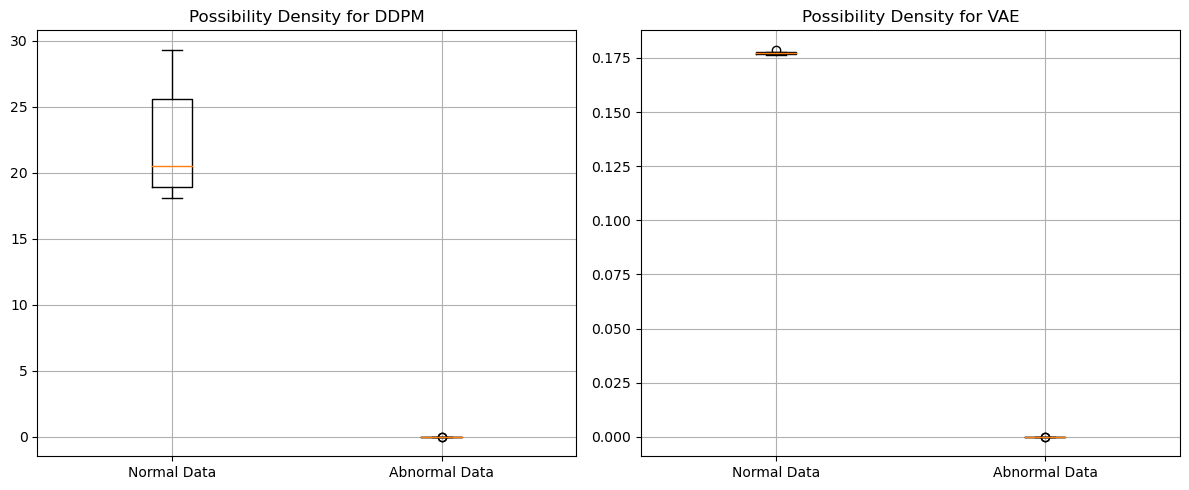

In [16]:
import matplotlib.pyplot as plt
import torch
%matplotlib inline

ddpm_norm = torch.load("results/ddpm_normal_pdf.pt", weights_only=True)
ddpm_abnorm = torch.load("results/ddpm_abnormal_pdf.pt", weights_only=True)
vae_norm = torch.load("results/vae_normal_pdf.pt", weights_only=True)
vae_abnorm = torch.load("results/vae_abnormal_pdf.pt", weights_only=True)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.boxplot([ddpm_norm, ddpm_abnorm])
plt.title("Possibility Density for DDPM")
plt.xticks([1, 2], ["Normal Data", "Abnormal Data"])
plt.grid()

plt.subplot(1, 2, 2)
plt.boxplot([vae_norm, vae_abnorm])
plt.title("Possibility Density for VAE")
plt.xticks([1, 2], ["Normal Data", "Abnormal Data"])
plt.grid()

plt.tight_layout()
plt.show()

From the results, we can conclude that the DDPM model is more effective in detecting the abnormal data points in the log dataset, compared to the VAE model. Nevertheless, both models finished the task with high accuracy, as the normal data points are much more likely to be normal than the abnormal data points. The data analysis results are consistent with the model characteristics, as the DDPM model is more capable of capturing the underlying data distribution of the input data.

We also want to mention that even though the results of our graph-based generation models meet the expectation, the detection score method we adopted here is very simple and naive. Much more sophisticated methods can be applied to improve the detection performance, like the ordinary differential equation (ODE) based score calculation. Due to the time limitation of the course project, we did not implement such advanced methods in this report.